# reloading model

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import random
import os
import pickle as pkl
import re
import datetime
from tqdm import tqdm
from typing import Optional, Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, TransformerEncoder, TransformerEncoderLayer, CosineEmbeddingLoss, MSELoss, Parameter
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torcheval.metrics import MulticlassAUROC
from sklearn.model_selection import train_test_split

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn.models import MLP
from torch_geometric.nn import GINConv, GATv2Conv
from torch_geometric.nn.norm import BatchNorm, GraphNorm
from torch_geometric.nn.pool import global_add_pool, global_mean_pool
from torch_geometric.utils import remove_self_loops, add_self_loops, mask_feature, mask_to_index, index_to_mask, to_dense_batch, select
from torch_geometric.nn.aggr.utils import (
    PoolingByMultiheadAttention,
    SetAttentionBlock,
)
from torch_geometric.experimental import disable_dynamic_shapes
from torch_geometric.nn.aggr import Aggregation, SetTransformerAggregation

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics.regression import ConcordanceCorrCoef
from lightning.pytorch.profilers import PyTorchProfiler

from torch_geometric.experimental import disable_dynamic_shapes
from torch_geometric.nn.aggr import Aggregation
from torch_geometric.nn.aggr.utils import (
    PoolingByMultiheadAttention,
    SetAttentionBlock,
)

torch.set_float32_matmul_precision('high')
L.seed_everything(42)

import sys
sys.path.append('/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/fine/')
from v0171_fine_gork_masked_corr_loss_minmax_norm_feature_high import *
sys.path.append('/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/pre/')
from v0171_pre_base_gork3_refine import LitAmiya, MyDataLoader


class FineTuningConfig:
    n_nei = 6
    nlayer_nei = 2
    batch_size = 64
    accumu_step = 5
    num_workers = 20
    
    nhead_outer = 1
    dropout_outer = 0.3
    S_res_weight = 1
    freeze_layers = True
    small_lr_layers = None

    max_epochs = 100
    lr = 0.0001
    weight_decay = 1e-5 # weight decay
    lr_small = 0.000001
    
    accelerator='gpu'
    devices = [5]
    # precision = "16-mixed"
    precision = "64"

    root_dir = './v0171_fine_gork_masked_corr_loss_minmax_norm_feature_high/'
    pre_train_ckpt = '/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/pre/v0171_pre_gork/Amiya_./v0171_pre_gork/version_3/checkpoints/best-epoch=13-Loss/val=0.54.ckpt'
    fine_tune_ckpt = '/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/fine/v0171_fine_gork_masked_corr_loss_no_norm/Amiya_./v0171_fine_gork_masked_corr_loss_no_norm/version_0/checkpoints/best-epoch=3-Loss/val=503418724247831.75.ckpt'
    
    test_size = 0.2 
    val_size = 0.1
    drop_last = True

    ref_tag = 'maldi'
    reg_weight = 1e-4
    lw_corr_mean = 0.5
    lw_corr = 0.3
    lw_corr_col = 1
    
    record_flag = True


cfg = FineTuningConfig()


graph_list, met_edge, S, S_tensor, avi_genes, mapped_id_dict_list, index_mapping_list, rm_edge_index = data_preparing(
    graph_list = '/data/home/liuzhaoyang/data/GBM_Spatial_MultiOmics/GBM_sct_counts_graph_list.pth',
    met_edge = '/data/home/liuzhaoyang/ES/project/MetaSpace/edge_index_without_com_dedup.pkl',
    S_file = '/data/home/liuzhaoyang/ES/project/MetaSpace/S_without_com_trim_dedup.tsv',
    avi_genes = '/data/home/liuzhaoyang/ES/project/MetaSpace/avi_genes.txt',
    graph_metID_key = 'met_HMDB_ID',
    query_metID_key='HMDB',
    target_metID_key='KEGG',
    ref_tag=cfg.ref_tag,
    verbose=True
)
n_gene = len(avi_genes)
n_rxn = S_tensor.size(0)
n_met = S_tensor.size(1)


# reloading pre-trained model
pre_trained_lit_amiya = LitAmiya.load_from_checkpoint(
    cfg.pre_train_ckpt,
    met_edge_index=met_edge,
    lr=cfg.lr,
    wd=cfg.weight_decay,
    record_flag=True,
    n_gene=n_gene,
    n_rxn=n_rxn
)

model, train_data, val_data, test_data = setup_training(cfg, pre_trained_lit_amiya, graph_list, met_edge, n_rxn, n_met, S_tensor, rm_edge_index, index_mapping_list)


model = LitAmiyaFineTune.load_from_checkpoint(
    cfg.fine_tune_ckpt,
        pre_trained_lit_amiya=pre_trained_lit_amiya,
        met_edge_index=met_edge,
        n_rxn=n_rxn,
        n_met=n_met,
        S_init=S_tensor,
        rm_edge_index=rm_edge_index,
        index_mapping_list=index_mapping_list
    )

In [2]:
model

LitAmiyaFineTune(
  (amiya): Amiya(
    (feature_mask_tokens): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (1): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (2): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (3): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (4): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (5): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (6): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (7): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (8): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (9): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (10): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (11): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
    )
    (input_gn): GraphNorm(17856)
    (

# clustering using gene expression & find diff mets

In [13]:
import matplotlib.pyplot as plt

In [89]:
device = 'cuda:0'

model = model.to(device)
model.eval()

test_graphs = graph_list[-1]
test_data = merge_graphs([test_graphs])

test_loader = MyDataLoader(
            test_data.to(device),
            num_neighbors=[cfg.n_nei] * cfg.nlayer_nei,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            drop_last=cfg.drop_last
        )

X_met_list, X_ref_list = [], []
real_outputs, real_pos = [], []
real_ref, real_gene = [], []
for tmp_graph in tqdm(test_loader):
    tmp_met, mask_info = model(tmp_graph)
    tmp_ref = tmp_graph['met_ref']
    selected_met, selected_ref = model._select_share_met(tmp_met, tmp_ref, tmp_graph['graph_idx'])
    X_met_list.append(selected_met.detach().cpu())
    X_ref_list.append(selected_ref.detach().cpu())
    tmp_batch = tmp_graph['batch'].detach().cpu()

    tmp_b = 0
    tmp_spots = []
    for i in range(tmp_batch.size(0)):
        if tmp_batch[i] == tmp_b:
            tmp_spots.append(i)
            tmp_b += 1
        if tmp_b == tmp_batch.max():
            break
    real_outputs.append(selected_met[tmp_spots,:].detach().cpu())
    real_pos.append(tmp_graph['pos'][tmp_spots,:].detach().cpu())
    real_ref.append(selected_ref[tmp_spots,:].detach().cpu())
    real_gene.append(tmp_graph.x[tmp_spots,:].detach().cpu())
        
X_met = torch.concat(X_met_list, dim=0)
X_ref = torch.concat(X_ref_list, dim=0)
X_real_out = torch.concat(real_outputs, dim=0)
X_real_pos = torch.concat(real_pos, dim=0)
X_real_ref = torch.concat(real_ref, dim=0)
X_real_gene = torch.concat(real_gene, dim=0)

X_real_out = torch.concat(real_outputs, dim=0)
X_real_out[X_real_out == np.inf] = 99999

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.14it/s]


/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(3339, 14994)


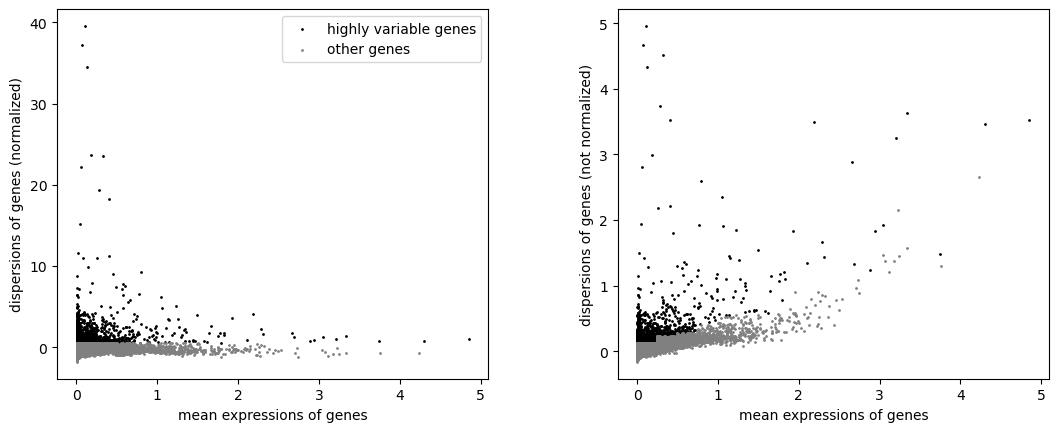

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


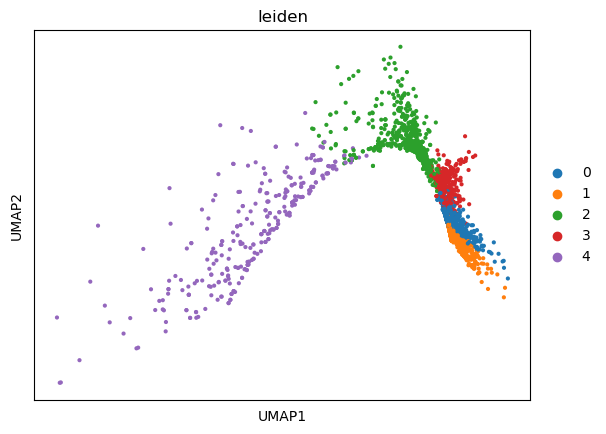

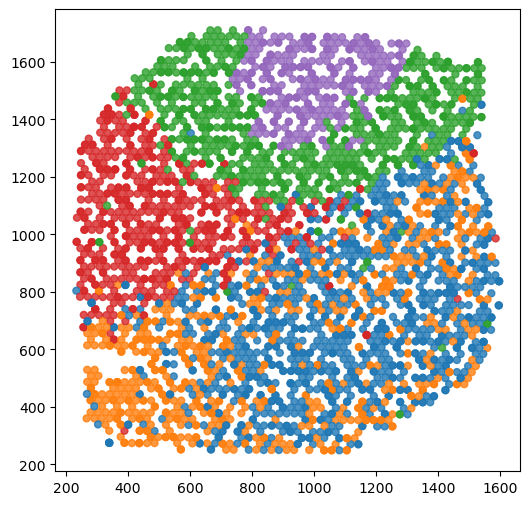

In [18]:
expression_df = pd.DataFrame(X_real_gene.numpy())
positions_df = pd.DataFrame(X_real_pos.numpy())

# Create an AnnData object
adata = sc.AnnData(X=expression_df.values, obs=positions_df)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)
# Preprocess the data
sc.pp.normalize_total(adata, inplace=True)  # Normalize total counts per cell
sc.pp.log1p(adata)  # Log-transform the data
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

sc.pp.scale(adata)  # Scale the data
sc.tl.pca(adata)
# Spatial clustering
sc.pp.neighbors(adata, use_rep='X_pca', method='umap')  # Compute neighborhood graph
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.35)  # Perform Leiden clustering

sc.pl.highly_variable_genes(adata)
sc.pl.umap(adata, color=["leiden"])

clusters = adata.obs['leiden']
cluster_colors = adata.uns['leiden_colors']

plt.figure(figsize=(6,6))
plt.scatter(x=X_real_pos[:,0], y=X_real_pos[:,1], color=[cluster_colors[int(tmp_c)] for tmp_c in list(clusters)],
           s=25, alpha=0.8)
plt.show()

In [23]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419:

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  dot_ax.scatter(x, y, **kwds)


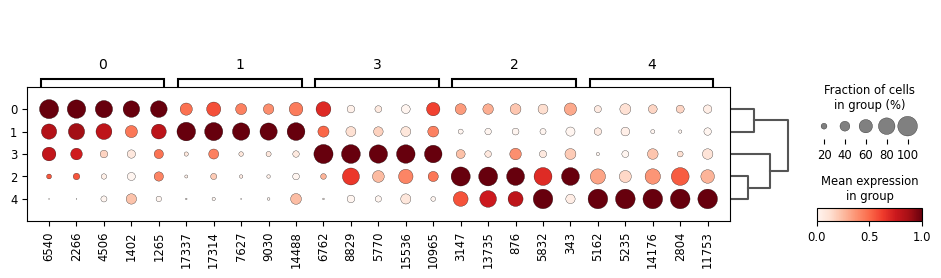

In [25]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

In [ ]:
# set met IDs as var.names

test_met_mapping_dic = index_mapping_list[-1]

S_keggID = met_id_mapping(list(S.index), 'recon_id_no_comp','KEGG')

In [80]:
adata_met.var_names

Index(['C05488', 'C11061', 'C00236', 'C04823', 'C00109', 'C00322', 'C00355',
       'C00942', 'C01060', 'C00632',
       ...
       'C00398', 'C06424', 'C00043', 'C00105', 'C00106', 'C00299', 'C00075',
       'C00385', 'C13550', 'C01762'],
      dtype='object', length=199)

In [88]:
X_real_out

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_gen

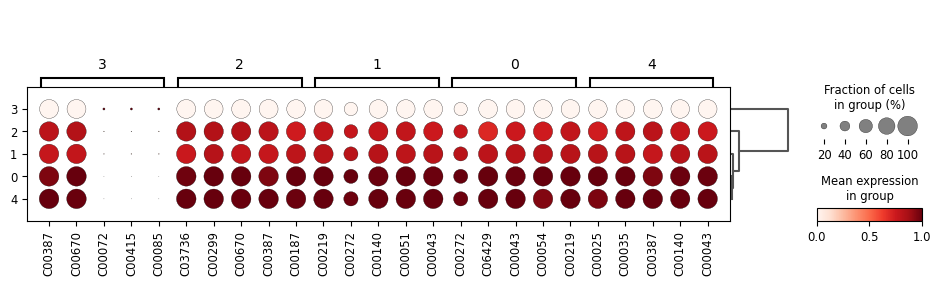

In [90]:
adata_met = sc.AnnData(X=X_real_out.detach().numpy(), obs=positions_df)
adata_met.var_names = [S_keggID[list(S_keggID)[i]] for i in list(test_met_mapping_dic.keys())]

sc.pp.normalize_total(adata_met)  # Normalize total counts per cell
sc.pp.log1p(adata_met)  # Log-transform the data
sc.pp.scale(adata_met)  # Scale the data

adata_met.obs['leiden'] = adata.obs['leiden']

sc.tl.rank_genes_groups(adata_met, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata_met, groupby="leiden", standard_scale="var", n_genes=5
)

In [83]:
adata_met

AnnData object with n_obs × n_vars = 3339 × 199
    obs: 0, 1, 'leiden'
    var: 'mean', 'std'
    uns: 'log1p', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca'

# output test graph for SpaDo

In [92]:
test_graphs

Data(x=[3414, 17856], edge_index=[2, 7064], pos=[3414, 2], rxn_exp=[3414, 3803], maldi=[3414, 863], met_HMDB_ID=[863], graph_idx=[3414])

In [93]:
adata

AnnData object with n_obs × n_vars = 3339 × 14994
    obs: 0, 1, 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [95]:
sum(adata.var['highly_variable'])

2000

In [97]:
adata.X[:,adata.var['highly_variable']]

array([[-0.15670766, -0.28600162, -0.58182925, ..., -0.43004945,
        -0.45105705, -0.32667425],
       [-0.15670766, -0.28600162, -0.58182925, ..., -0.43004945,
        -0.45105705, -0.32667425],
       [-0.15670766, -0.28600162, -0.58182925, ..., -0.43004945,
         3.4685564 , -0.32667425],
       ...,
       [-0.15670766, -0.28600162, -0.58182925, ..., -0.43004945,
        -0.45105705, -0.32667425],
       [-0.15670766, -0.28600162, -0.58182925, ..., -0.43004945,
        -0.45105705, -0.32667425],
       [-0.15670766, -0.28600162, -0.58182925, ..., -0.43004945,
        -0.45105705,  2.767108  ]], dtype=float32)

In [103]:
spado_in_decon = pd.DataFrame(adata.X[:,adata.var['highly_variable']])
spado_in_decon.index = ['S{}'.format(tmp_s) for tmp_s in adata.obs_names]
spado_in_decon.columns = ['G{}'.format(tmp_g) for tmp_g in adata.var_names[adata.var['highly_variable']]]

In [104]:
spado_in_decon

,G3,G4,G12,G14,G16,G23,G33,G42,G59,G92,...,G17810,G17813,G17819,G17824,G17828,G17830,G17836,G17840,G17845,G17851
S0,-0.156708,-0.286002,-0.581829,-0.509897,-0.058685,-0.366865,-0.374394,-0.309384,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
S1,-0.156708,-0.286002,-0.581829,1.130202,-0.058685,-0.366865,-0.374394,-0.309384,-0.110001,-0.287845,...,-0.511466,1.816252,-0.205981,-0.088066,1.871760,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
S2,-0.156708,-0.286002,-0.581829,-0.509897,-0.058685,-0.366865,-0.374394,-0.309384,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,3.468556,-0.326674
S3,-0.156708,-0.286002,1.418466,-0.509897,-0.058685,-0.366865,-0.374394,3.114906,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
S4,-0.156708,-0.286002,1.080491,-0.509897,-0.058685,-0.366865,3.415056,-0.309384,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,1.701889,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S3334,-0.156708,-0.286002,-0.581829,-0.509897,-0.058685,-0.366865,-0.374394,3.251715,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
S3335,-0.156708,-0.286002,-0.581829,1.377670,-0.058685,-0.366865,-0.374394,-0.309384,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
S3336,-0.156708,-0.286002,-0.581829,-0.509897,-0.058685,-0.366865,-0.374394,-0.309384,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674
S3337,-0.156708,-0.286002,-0.581829,-0.509897,-0.058685,-0.366865,-0.374394,3.253617,-0.110001,-0.287845,...,-0.511466,-0.410245,-0.205981,-0.088066,-0.425780,-0.183285,-0.070707,-0.430049,-0.451057,-0.326674


In [110]:
spado_in_pos = pd.DataFrame(adata.obs).iloc[:,:2]
spado_in_pos.index = ['S{}'.format(tmp_s) for tmp_s in adata.obs_names]
spado_in_pos.columns = ['X','Y']

In [112]:
spado_in_pos

,X,Y
S0,721,801
S1,380,761
S2,440,740
S3,1145,608
S4,298,1248
...,...,...
S3334,1307,1178
S3335,1148,1073
S3336,577,1182
S3337,987,672


In [114]:
spado_in_decon.to_csv('/data/home/liuzhaoyang/ES/project/MetaSpace/SpaDo//SpaDo_in_decon_GBM_slice_6.tsv', sep='\t')
spado_in_pos.to_csv('/data/home/liuzhaoyang/ES/project/MetaSpace/SpaDo//SpaDo_in_pos_GBM_slice_6.tsv', sep='\t')

# try using the newest fine-tuning model

In [115]:
fine_tune_ckpt = '/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/fine/v0171_fine_gork_masked_corr_huber_loss_minmax_norm_r3/Amiya_./v0171_fine_gork_masked_corr_huber_loss_minmax_norm_r3/version_8/checkpoints/best-epoch=81-Loss/'

In [2]:
import sys
sys.path.append('/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/pre/')
from v0171_fine_gork_masked_corr_huber_loss_minmax_norm_r3 import *
from v0171_pre_base_gork3_refine_r2 import LitAmiya, MyDataLoader


class FineTuningConfig:
    n_nei = 6
    nlayer_nei = 2
    batch_size = 64
    accumu_step = 5
    num_workers = 20
    
    nhead_outer = 1
    dropout_outer = 0.3
    S_res_weight = 1
    freeze_layers = True
    small_lr_layers = None

    max_epochs = 100
    lr = 0.0001
    weight_decay = 1e-5 # weight decay
    lr_small = 0.000001
    
    accelerator='gpu'
    devices = [5]
    # precision = "16-mixed"
    precision = "64"

    root_dir = './v0171_fine_gork_masked_corr_loss_minmax_norm_feature_high/'
    pre_train_ckpt = '/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/pre/v0171_pre_gork_r2/Amiya_./v0171_pre_gork_r2/version_0/checkpoints/best-epoch=5-Loss/val=0.54.ckpt'
    fine_tune_ckpt = '/data/home/liuzhaoyang/ES/project/MetaSpace/large_ST/v0171/fine/v0171_fine_gork_masked_corr_huber_loss_minmax_norm_r3/Amiya_./v0171_fine_gork_masked_corr_huber_loss_minmax_norm_r3/version_8/checkpoints/best-epoch=190-Loss/val=0.43.ckpt'
    
    test_size = 0.2 
    val_size = 0.1
    drop_last = True

    ref_tag = 'maldi'
    reg_weight = 1e-4
    lw_corr_mean = 0.5
    lw_corr = 0.3
    lw_corr_col = 1
    
    record_flag = True


cfg = FineTuningConfig()


graph_list, met_edge, S, S_tensor, avi_genes, mapped_id_dict_list, index_mapping_list, rm_edge_index = data_preparing(
    graph_list = '/data/home/liuzhaoyang/data/GBM_Spatial_MultiOmics/GBM_sct_counts_graph_list.pth',
    met_edge = '/data/home/liuzhaoyang/ES/project/MetaSpace/edge_index_without_com_dedup.pkl',
    S_file = '/data/home/liuzhaoyang/ES/project/MetaSpace/S_without_com_trim_dedup.tsv',
    avi_genes = '/data/home/liuzhaoyang/ES/project/MetaSpace/avi_genes.txt',
    graph_metID_key = 'met_HMDB_ID',
    query_metID_key='HMDB',
    target_metID_key='KEGG',
    ref_tag=cfg.ref_tag,
    verbose=True
)
n_gene = len(avi_genes)
n_rxn = S_tensor.size(0)
n_met = S_tensor.size(1)


# reloading pre-trained model
pre_trained_lit_amiya = LitAmiya.load_from_checkpoint(
    cfg.pre_train_ckpt,
    met_edge_index=met_edge,
    lr=cfg.lr,
    wd=cfg.weight_decay,
    record_flag=True,
    n_gene=n_gene,
    n_rxn=n_rxn
)

model, train_data, val_data, test_data = setup_training(cfg, pre_trained_lit_amiya, graph_list, met_edge, n_rxn, n_met, S_tensor, rm_edge_index, index_mapping_list)



model = LitAmiyaFineTune.load_from_checkpoint(
    cfg.fine_tune_ckpt,
        pre_trained_lit_amiya=pre_trained_lit_amiya,
        met_edge_index=met_edge,
        n_rxn=n_rxn,
        n_met=n_met,
        S_init=S_tensor,
        rm_edge_index=rm_edge_index,
        index_mapping_list=index_mapping_list
    )


graph 1/7: 863 met mapped, 199 met found in avi met model
graph 2/7: 863 met mapped, 199 met found in avi met model
graph 3/7: 863 met mapped, 199 met found in avi met model
graph 4/7: 863 met mapped, 199 met found in avi met model
graph 5/7: 863 met mapped, 199 met found in avi met model
graph 6/7: 863 met mapped, 199 met found in avi met model


/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'pre_trained_lit_amiya' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['pre_trained_lit_amiya'])`.


In [3]:
model

LitAmiyaFineTune(
  (amiya): Amiya(
    (feature_mask_tokens): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (1): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (2): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (3): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (4): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (5): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (6): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (7): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (8): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (9): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (10): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
        (11): Parameter containing: [torch.float32 of size 1x256 (GPU 1)]
    )
    (input_gn): GraphNorm(17856)
    (

In [4]:
device = 'cuda:0'

model = model.to(device)
model.eval()

test_graphs = graph_list[-1]
test_data = merge_graphs([test_graphs])

test_loader = MyDataLoader(
            test_data.to(device),
            num_neighbors=[cfg.n_nei] * cfg.nlayer_nei,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            drop_last=cfg.drop_last
        )

X_met_list, X_ref_list = [], []
real_outputs, real_pos = [], []
real_ref, real_gene = [], []
for tmp_graph in tqdm(test_loader):
    tmp_met_pack, mask_info = model(tmp_graph)
    tmp_met, X_rxn, X_rxn_attn, attn_weight, gat_weight = tmp_met_pack
    tmp_ref = tmp_graph['met_ref']
    selected_met, selected_ref = model._select_share_met(tmp_met, tmp_ref, tmp_graph['graph_idx'])
    X_met_list.append(selected_met.detach().cpu())
    X_ref_list.append(selected_ref.detach().cpu())
    tmp_batch = tmp_graph['batch'].detach().cpu()

    tmp_b = 0
    tmp_spots = []
    for i in range(tmp_batch.size(0)):
        if tmp_batch[i] == tmp_b:
            tmp_spots.append(i)
            tmp_b += 1
        if tmp_b == tmp_batch.max():
            break
    real_outputs.append(selected_met[tmp_spots,:].detach().cpu())
    real_pos.append(tmp_graph['pos'][tmp_spots,:].detach().cpu())
    real_ref.append(selected_ref[tmp_spots,:].detach().cpu())
    real_gene.append(tmp_graph.x[tmp_spots,:].detach().cpu())
        
X_met = torch.concat(X_met_list, dim=0)
X_ref = torch.concat(X_ref_list, dim=0)
X_real_out = torch.concat(real_outputs, dim=0)
X_real_pos = torch.concat(real_pos, dim=0)
X_real_ref = torch.concat(real_ref, dim=0)
X_real_gene = torch.concat(real_gene, dim=0)

X_real_out = torch.concat(real_outputs, dim=0)
# X_real_out[X_real_out == np.inf] = 99999

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.14it/s]


In [5]:
X_real_out

tensor([[0.4974, 0.5146, 0.5128,  ..., 0.4931, 0.5047, 0.4946],
        [0.5210, 0.5200, 0.4942,  ..., 0.5270, 0.5148, 0.4972],
        [0.5262, 0.5003, 0.5156,  ..., 0.5208, 0.4909, 0.4943],
        ...,
        [0.4940, 0.4969, 0.4930,  ..., 0.5019, 0.5273, 0.5038],
        [0.4760, 0.5279, 0.5208,  ..., 0.4818, 0.4996, 0.4963],
        [0.4983, 0.4937, 0.5150,  ..., 0.5043, 0.4768, 0.4947]])

In [6]:
import scanpy as sc
from matplotlib import pyplot as plt

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(3339, 14994)


/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/fs/home/liuzhaoyang/biosoft/mambaforge/envs

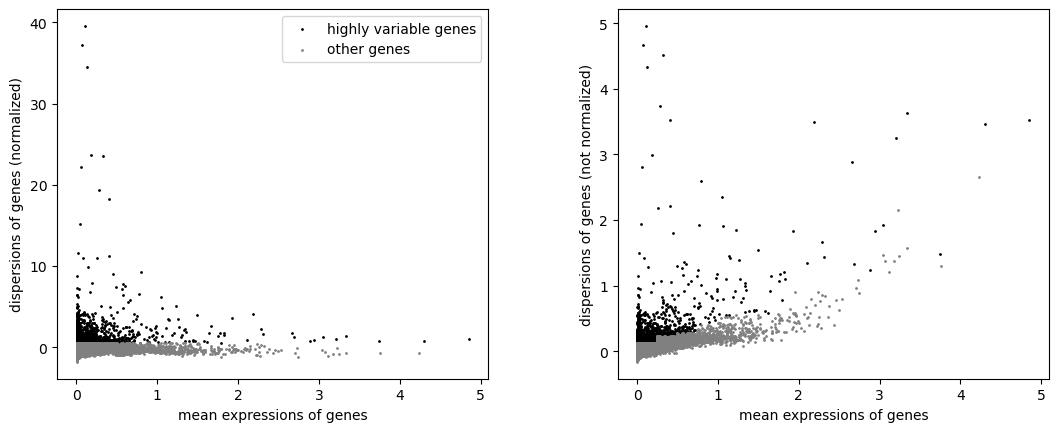

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


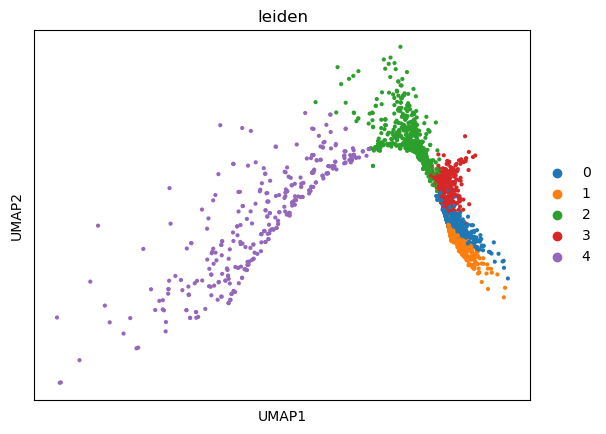

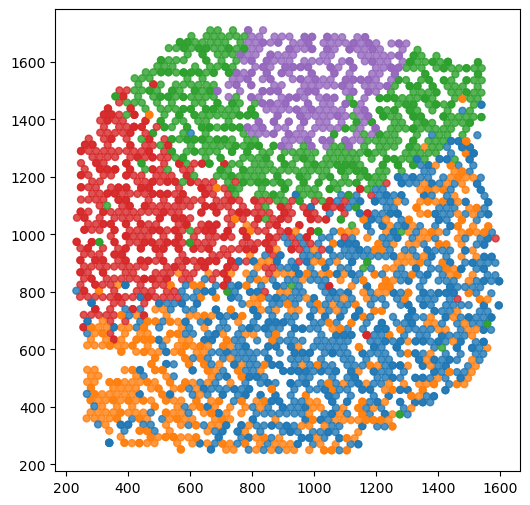

In [7]:
expression_df = pd.DataFrame(X_real_gene.numpy())
positions_df = pd.DataFrame(X_real_pos.numpy())

# Create an AnnData object
adata = sc.AnnData(X=expression_df.values, obs=positions_df)
adata.var_names = avi_genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)
# Preprocess the data
sc.pp.normalize_total(adata, inplace=True)  # Normalize total counts per cell
sc.pp.log1p(adata)  # Log-transform the data
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

sc.pp.scale(adata)  # Scale the data
sc.tl.pca(adata)
# Spatial clustering
sc.pp.neighbors(adata, use_rep='X_pca', method='umap')  # Compute neighborhood graph
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.35)  # Perform Leiden clustering

sc.pl.highly_variable_genes(adata)
sc.pl.umap(adata, color=["leiden"])

clusters = adata.obs['leiden']
cluster_colors = adata.uns['leiden_colors']

plt.figure(figsize=(6,6))
plt.scatter(x=X_real_pos[:,0], y=X_real_pos[:,1], color=[cluster_colors[int(tmp_c)] for tmp_c in list(clusters)],
           s=25, alpha=0.8)
plt.show()

# using SpaDo clustering results

In [8]:
hcluster = pd.read_csv('/mnt/Venus/home/liuzhaoyang/project/MetaSpace/SpaDo/SpaDo_out_hcluster_GBM_slice_6.tsv', sep='\t')

hcluster.index = [tmp_i[1:] for tmp_i in list(hcluster.index)]

adata.obs['spado'] = hcluster.iloc[:,-1].astype('category')

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419:

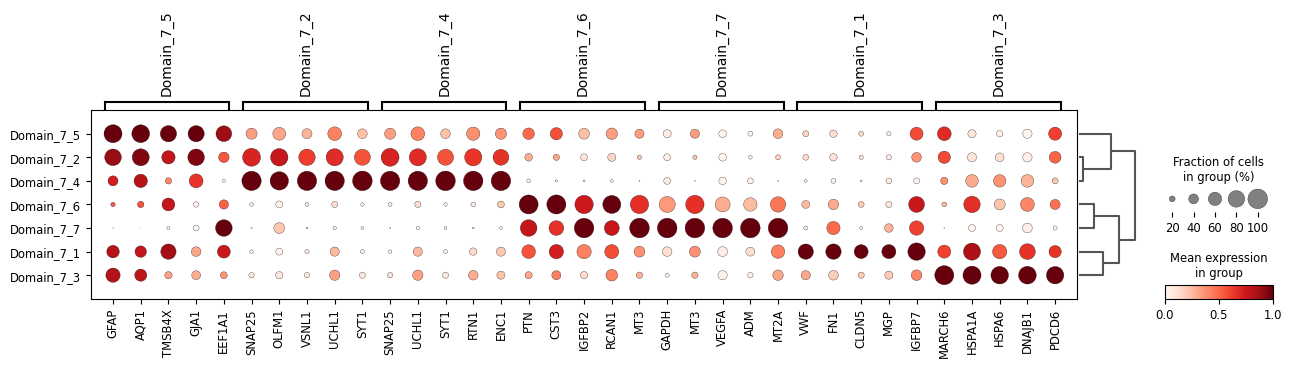

In [9]:
sc.tl.rank_genes_groups(adata, "spado", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="spado", standard_scale="var", n_genes=5
)

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
         Falling back to preprocessing with `sc.pp.pca` and default params.
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  dot_ax.scatter(x, y, **kwds)


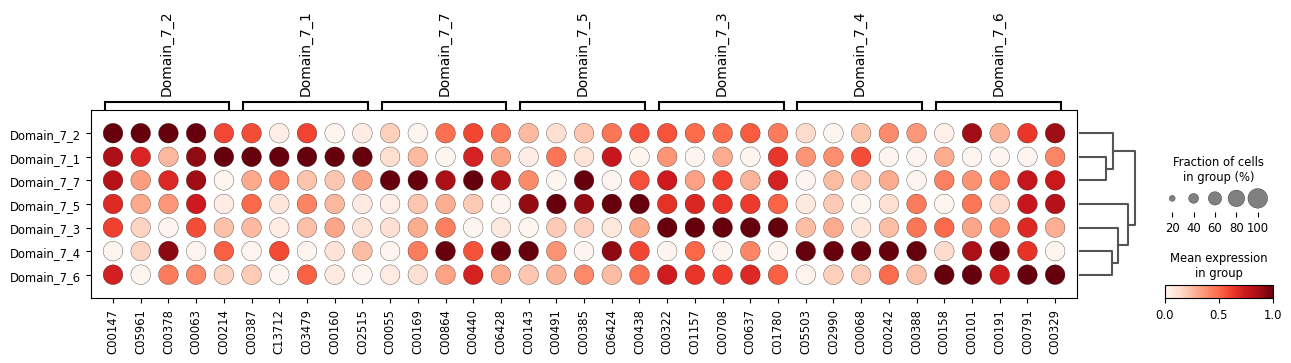

In [11]:
adata_met = sc.AnnData(X=X_real_out.detach().clone().numpy(), obs=positions_df)
S_keggID = met_id_mapping(list(S.index), 'recon_id_no_comp','KEGG')
adata_met.var_names = [S_keggID[list(S_keggID)[i]] for i in list(index_mapping_list[-1].keys())]

# sc.pp.normalize_total(adata_met)  # Normalize total counts per cell
# sc.pp.log1p(adata_met)  # Log-transform the data
# sc.pp.scale(adata_met)  # Scale the data

adata_met.obs['leiden'] = adata.obs['leiden']
adata_met.obs['spado'] = adata.obs['spado']

sc.tl.rank_genes_groups(adata_met, "spado", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata_met, groupby="spado", standard_scale="var", n_genes=5
)

/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/fs/home/liuzhaoyang/biosoft/mambaforge/envs/MS/lib/python3.11/site-packages/scanpy/tools/_rank_gen

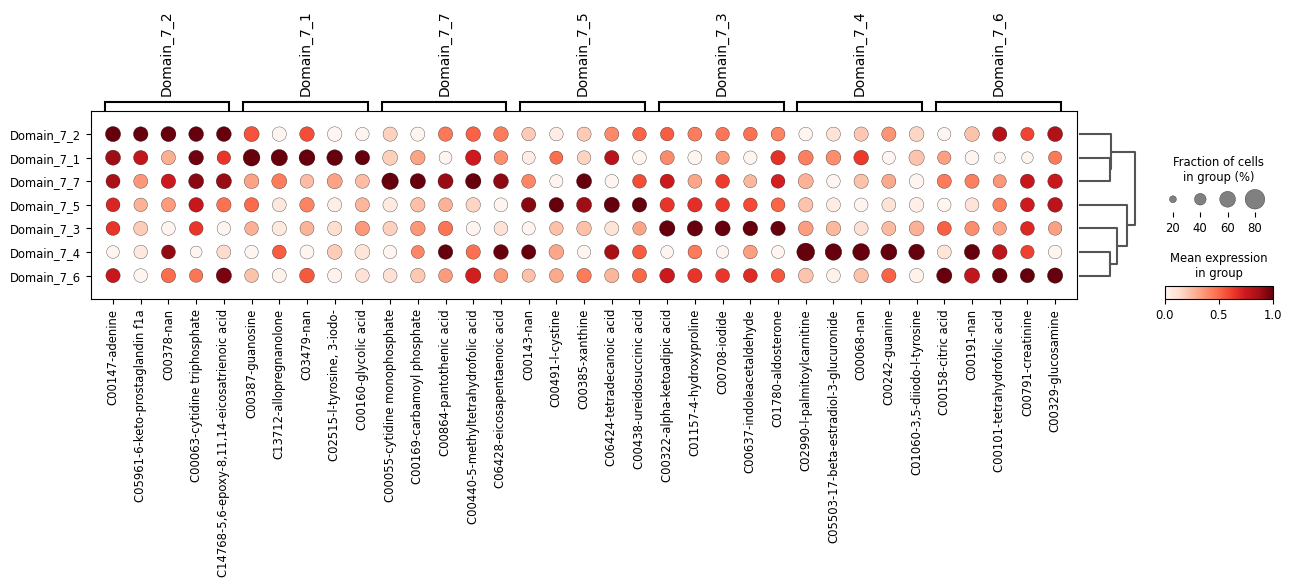

In [12]:
adata_met = sc.AnnData(X=X_real_out.detach().clone().numpy(), obs=positions_df)
S_keggID = met_id_mapping(list(S.index), 'recon_id_no_comp','KEGG')
S_Name = met_id_mapping(list(S.index), 'recon_id_no_comp','Name')
adata_met.var_names = ['{}-{}'.format(S_keggID[list(S_keggID)[i]], S_Name[list(S_Name)[i]]) for i in list(index_mapping_list[-1].keys())]
adata_met.var_names_make_unique()

sc.pp.normalize_total(adata_met)  # Normalize total counts per cell
sc.pp.log1p(adata_met)  # Log-transform the data
sc.pp.scale(adata_met)  # Scale the data

adata_met.obs['leiden'] = adata.obs['leiden']
adata_met.obs['spado'] = adata.obs['spado']

sc.tl.rank_genes_groups(adata_met, "spado", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata_met, groupby="spado", standard_scale="var", n_genes=5
)

# check the CosSim between Amiya and Compass

In [13]:
from torch.nn import CosineSimilarity

In [14]:
cos_spot = CosineSimilarity(dim=1)
cos_met = CosineSimilarity(dim=0)

In [19]:
torch.nanmedian(cos_spot(X_real_out, X_real_ref))

tensor(0.7911)

In [20]:
torch.nanmedian(cos_met(X_real_out, X_real_ref))

tensor(0.8956)

In [39]:
import seaborn as sns

Text(0.5, 1.0, 'CosineSimilarity between Spots')

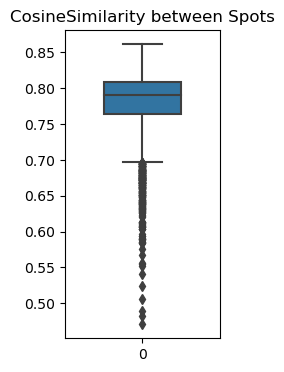

In [48]:
plt.figure(figsize=(2,4))
sns.boxplot(pd.Series(cos_spot(X_real_out, X_real_ref).numpy()), width=0.5)
plt.title('CosineSimilarity between Spots')

Text(0.5, 1.0, 'CosineSimilarity between Mets')

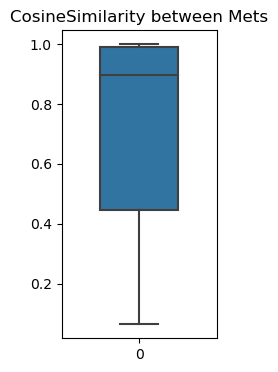

In [49]:
plt.figure(figsize=(2,4))
sns.boxplot(pd.Series(cos_met(X_real_out, X_real_ref).numpy()), width=0.5)
plt.title('CosineSimilarity between Mets')

In [52]:
mapID_ref = pd.read_csv('/data/home/liuzhaoyang/ES/project/MetaSpace/met_model/Amiya_met_meta.tsv', sep='\t', index_col=0)

In [53]:
mapID_ref.columns

Index(['recon_id_flat', 'initialConcentration', 'charge', 'recon_name',
       'sbo_term', 'compartment', 'formula', 'smiles', 'recon_id',
       'recon_id_no_comp', 'degree', 'KEGG', 'HMDB_5bit', 'HMDB', 'CAS',
       'DTXSID', 'DTXCID', 'SID', 'CID', 'ChEBI', 'Drugbank', 'Name'],
      dtype='object')

In [56]:
mapID_ref['recon_id_no_comp']

0          10fthf
1          10fthf
2          10fthf
3          10fthf
4       11docrtsl
          ...    
2968        yvite
2969        yvite
2970     zym_int2
2971        zymst
2972      zymstnl
Name: recon_id_no_comp, Length: 2973, dtype: object

In [58]:
mapID_ref['Name']

0       10-formyltetrahydrofolate
1       10-formyltetrahydrofolate
2       10-formyltetrahydrofolate
3       10-formyltetrahydrofolate
4                     cortodoxone
                  ...            
2968         (+)-gamma-tocopherol
2969         (+)-gamma-tocopherol
2970     zymosterol intermediate 
2971     zymosterol intermediate 
2972                   zymostenol
Name: Name, Length: 2973, dtype: object

### process compass

In [ ]:
compass_df = pd.read_csv('/mnt/Venus/home/liuzhaoyang/data/GBM_Spatial_MultiOmics/275_T/Compass/reactions.tsv',
                        sep='\t', index_col=0)

sys.path.append('/mnt/Venus/home//liuzhaoyang/project/MetaSpace/')
import processing as MSpp

avi_meta = '/data/home/liuzhaoyang/ES/project/MetaSpace/annotated_metabolite_HMDB_ID.txt'
with open(avi_meta, 'r') as f:
    avi_meta = f.read().strip().split('\n')

S_meta_mapping = MSpp.build_S_meta_mapping(S, avi_meta, with_compartment=False, verbose=True,
                                              met_md_path='/data/home/liuzhaoyang/ES/project/MetaSpace/met_md.csv')

In [30]:
compass_df_rxns = [tmp_rxn[:-4] for tmp_rxn in list(compass_df.index)]

compass_df = compass_df.loc[np.isin(compass_df_rxns, list(S.columns)),:]

compass_df_direction = [1 if tmp_rxn[-3:] == 'pos' else -1 for tmp_rxn in list(compass_df.index)]
for i in range(compass_df.shape[0]):
    compass_df.iloc[i,:] = compass_df.iloc[i,:]*compass_df_direction[i]
# compass_df.iloc[:,:-1].multiply(pd.DataFrame(compass_df_direction))

compass_df['rxn'] = [tmp_rxn[:-4] for tmp_rxn in list(compass_df.index)]

tmp_list = []
rxn_list = list(set([tmp_rxn[:-4] for tmp_rxn in list(compass_df.index)]))
for tmp_i, tmp_rxn in enumerate(rxn_list):
    tmp_df = compass_df.loc[compass_df.rxn == tmp_rxn,:].iloc[:,:-1]
    if tmp_df.shape[0] > 1:
        tmp_df = tmp_df.sum(axis=0)
        tmp_df = pd.DataFrame(tmp_df).T
        # tmp_df.index = [tmp_rxn]   
    tmp_list.append(tmp_df.iloc[0,:].values)

compass_248_T_nodirect_df = pd.DataFrame(tmp_list)
compass_248_T_nodirect_df.index = rxn_list
compass_248_T_nodirect_df.columns = list(compass_df.columns)[:-1]

S_trim = S.loc[:,np.isin(S.columns, compass_248_T_nodirect_df.index)]
compass_metabolite = S_trim.dot(compass_248_T_nodirect_df)

compass_metabolite = pd.concat([compass_metabolite, S_meta_mapping], axis=1)
compass_metabolite.dropna(inplace=True)

In [31]:
compass_metabolite.shape

(230, 3415)

In [59]:
compass_metabolite = compass_metabolite.iloc[:,:-1]

In [60]:
compass_metabolite

,AAACAAGTATCTCCCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACAGTGTTCCTGGG-1,AAACATTTCCCGGATT-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,...,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1
11docrtsl,0.000000,0.000000,0.000000,0.000000,2.910383e-11,2.910383e-11,1.455192e-11,1.455192e-11,0.000000,1.455192e-11,...,1.455192e-11,1.455192e-11,0.000000,0.000000,0.000000,2.910383e-11,0.000000,0.000000,0.000000,1.455192e-11
13_cis_retnglc,13294.016952,12407.291087,12569.695765,12747.816415,1.248000e+04,1.260640e+04,1.317030e+04,1.245992e+04,13426.921771,1.211757e+04,...,1.361603e+04,1.268878e+04,12111.433623,12746.080508,12865.218437,1.317422e+04,12949.492473,13148.099649,12431.972261,1.225712e+04
13dpg,28879.137205,27803.236647,29441.392182,28871.103865,2.583627e+04,2.785618e+04,2.985281e+04,2.640039e+04,30006.728108,2.739369e+04,...,2.885054e+04,2.903309e+04,29446.262405,29472.326948,31937.789843,3.230540e+04,28699.979342,28482.659803,28148.009192,2.874021e+04
25aics,-42603.458459,-40544.635031,-40571.616847,-40523.233351,-4.101535e+04,-4.209748e+04,-4.306207e+04,-4.230103e+04,-43848.581562,-3.915784e+04,...,-4.253909e+04,-4.128081e+04,-40634.611418,-42237.741303,-43517.946286,-4.334454e+04,-42784.385899,-42046.306556,-42809.873288,-3.968948e+04
2mcit,25825.153468,25114.062941,25035.092600,24954.519690,2.489441e+04,2.494055e+04,2.544334e+04,2.432770e+04,25984.429417,2.422122e+04,...,2.592673e+04,2.523575e+04,24880.920458,26594.800254,25695.534838,2.561931e+04,26517.609498,25038.563113,24941.977604,2.535137e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uri,43002.529664,36704.994827,40875.178080,37648.561843,3.822719e+04,3.954023e+04,4.158962e+04,3.947246e+04,42846.982836,4.046887e+04,...,4.063450e+04,4.101861e+04,37346.019063,38637.817383,39792.136841,4.334447e+04,40185.046111,39937.164245,40617.475033,3.988175e+04
utp,-112980.820294,-96534.161575,-102482.185235,-99858.059789,-9.428660e+04,-9.779807e+04,-1.074248e+05,-9.492658e+04,-110534.032116,-9.507869e+04,...,-1.045005e+05,-9.917320e+04,-101593.644247,-97137.785737,-100252.230276,-1.109064e+05,-106952.850646,-105023.946841,-107651.553884,-1.022230e+05
xan,13877.843373,13645.818634,14625.016015,12906.693474,1.282121e+04,1.322108e+04,1.383505e+04,1.303289e+04,15122.643484,1.123564e+04,...,1.394089e+04,9.292883e+03,10433.352219,14046.156639,13937.635625,1.090049e+04,14741.631644,14870.807124,13677.598886,1.121074e+04
xol24oh,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00


In [35]:
X_ref.shape

torch.Size([10165, 199])

In [36]:
compass_ref = pd.read_csv('/mnt/Venus/home/liuzhaoyang/data/GBM_Spatial_MultiOmics/275_T/Integrated_ST_metabolite_275_T.tsv',
                        sep='\t', index_col=0)

In [ ]:
for tmp_i, tmp_id in enumerate(compass_metabolite.loc[:,'hmdbID']):
    ground_sr = metabolite_248_T_df.loc[tmp_id,:]


In [ ]:
compass_idmap = met_id_mapping(list(compass_metabolite.index), 'recon_id_no_comp','KEGG')